In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

IMG_SIZE = (224, 224)
BATCH_SIZE = 16
SEED = 123
EPOCHS = 20
CLASSES = 38

DATASET_PATH = '/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'
TEST_DIR_PATH = '/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid'

print("TensorFlow Version:", tf.__version__)
print("GPU Available:", len(tf.config.list_physical_devices('GPU')))

TensorFlow Version: 2.19.0
GPU Available: 1


#### Loading Data

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR_PATH,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int',
    shuffle=False
)

class_names = train_ds.class_names
print(f"\nDiscovered {len(class_names)} classes.")
print(f"Example classes: {class_names[:5]}")

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

Found 70295 files belonging to 38 classes.
Using 56236 files for training.


I0000 00:00:1766829865.245676      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 70295 files belonging to 38 classes.
Using 14059 files for validation.
Found 17572 files belonging to 38 classes.

Discovered 38 classes.
Example classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy']


## 1. Network Building (Base CNN)

#### Defining Model

In [3]:
model_1 = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    layers.Rescaling(1./255),   
    # Convolution Block 1
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    # Convolution Block 2
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    # Convolution Block 3
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    # Head
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(CLASSES, activation='softmax')
])

In [4]:
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 38)             │         4,902 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,173,862 (42.62 MB)

 Trainable params: 11,173,862 (42.62 MB)

 Non-trainable params: 0 (0.00 B)

#### Compiling Model

In [5]:
model_1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#### Training

In [6]:
history_1 = model_1.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)

Epoch 1/20


I0000 00:00:1766658870.833794     416 service.cc:148] XLA service 0x7d5e100049b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1766658870.834548     416 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1766658871.115814     416 cuda_dnn.cc:529] Loaded cuDNN version 90300


   9/3515 ━━━━━━━━━━━━━━━━━━━━ 54s 16ms/step - accuracy: 0.0138 - loss: 4.5204      

I0000 00:00:1766658873.967303     416 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 117s 25ms/step - accuracy: 0.5150 - loss: 1.7369 - val_accuracy: 0.8555 - val_loss: 0.4558
Epoch 2/20
3515/3515 ━━━━━━━━━━━━━━━━━━━━ 69s 17ms/step - accuracy: 0.8787 - loss: 0.3688 - val_accuracy: 0.8745 - val_loss: 0.3960
Epoch 3/20
3515/3515 ━━━━━━━━━━━━━━━━━━━━ 70s 17ms/step - accuracy: 0.9329 - loss: 0.2025 - val_accuracy: 0.8869 - val_loss: 0.3731
Epoch 4/20
3515/3515 ━━━━━━━━━━━━━━━━━━━━ 69s 17ms/step - accuracy: 0.9566 - loss: 0.1280 - val_accuracy: 0.8991 - val_loss: 0.3856
Epoch 5/20
3515/3515 ━━━━━━━━━━━━━━━━━━━━ 69s 17ms/step - accuracy: 0.9690 - loss: 0.0945 - val_accuracy: 0.8714 - val_loss: 0.5756
Epoch 6/20
3515/3515 ━━━━━━━━━━━━━━━━━━━━ 69s 17ms/step - accuracy: 0.9729 - loss: 0.0832 - val_accuracy: 0.8971 - val_loss: 0.4686
Epoch 7/20
3515/3515 ━━━━━━━━━━━━━━━━━━━━ 69s 17ms/step - accuracy: 0.9784 - loss: 0.0733 - val_accuracy: 0.9035 - val_loss: 0.4477
Epoch 8/20
3515/3515 ━━━━━━━━━━━━━━━━━━━━ 69s 17ms/step - accuracy: 0.9815 - loss: 0.0

In [7]:
model_1.save('model_1_simple_cnn.keras')

In [8]:
model_1.save('model_1_simple_cnn.h5')

#### Graph Plotting

In [11]:
def plot_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'{title}: Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'{title}: Loss')
    plt.show()

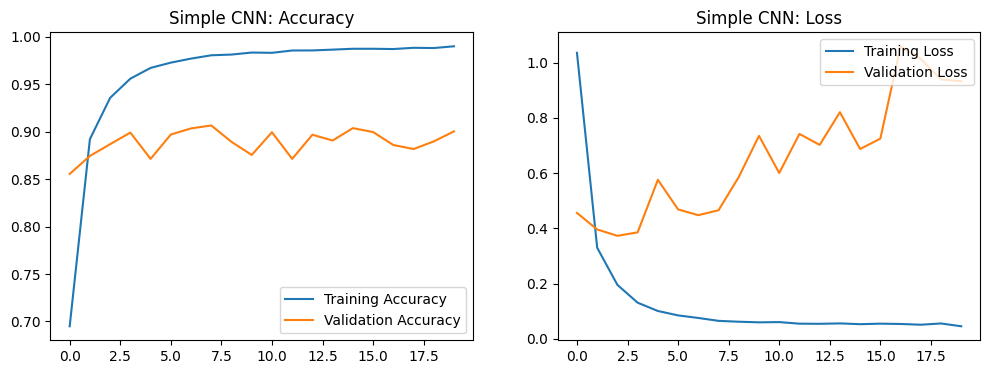

In [11]:
plot_history(history_1, "Simple CNN")

## 2. Network Building (CNN + New Data Augmentation) 

#### Augmentation Block

In [6]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.1),
])

#### Defining Model

In [5]:
model_2 = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    data_augmentation,
    layers.Rescaling(1./255),
    # adding Dropout
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dense(CLASSES, activation='softmax')
])

model_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 38)             │         4,902 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,173,862 (42.62 MB)

 Trainable params: 11,173,862 (42.62 MB)

 Non-trainable params: 0 (0.00 B)

#### Compiling Model

In [6]:
model_2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#### Fitting

In [7]:
history_2 = model_2.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)

Epoch 1/20


I0000 00:00:1766665836.216527     191 cuda_dnn.cc:529] Loaded cuDNN version 91002


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 160s 33ms/step - accuracy: 0.4479 - loss: 1.9318 - val_accuracy: 0.7794 - val_loss: 0.7255
Epoch 2/20
3515/3515 ━━━━━━━━━━━━━━━━━━━━ 92s 24ms/step - accuracy: 0.8059 - loss: 0.6181 - val_accuracy: 0.8637 - val_loss: 0.4316
Epoch 3/20
3515/3515 ━━━━━━━━━━━━━━━━━━━━ 92s 24ms/step - accuracy: 0.8648 - loss: 0.4233 - val_accuracy: 0.8718 - val_loss: 0.4089
Epoch 4/20
3515/3515 ━━━━━━━━━━━━━━━━━━━━ 92s 24ms/step - accuracy: 0.8868 - loss: 0.3486 - val_accuracy: 0.8679 - val_loss: 0.4329
Epoch 5/20
3515/3515 ━━━━━━━━━━━━━━━━━━━━ 92s 24ms/step - accuracy: 0.8970 - loss: 0.3167 - val_accuracy: 0.8740 - val_loss: 0.4109
Epoch 6/20
3515/3515 ━━━━━━━━━━━━━━━━━━━━ 92s 24ms/step - accuracy: 0.9103 - loss: 0.2806 - val_accuracy: 0.9208 - val_loss: 0.2421
Epoch 7/20
3515/3515 ━━━━━━━━━━━━━━━━━━━━ 91s 23ms/step - accuracy: 0.9161 - loss: 0.2630 - val_accuracy: 0.9211 - val_loss: 0.2518
Epoch 8/20
3515/3515 ━━━━━━━━━━━━━━━━━━━━ 92s 24ms/step - accuracy: 0.9188 - loss: 0.2

In [8]:
model_2.save('model_2_augmented_cnn.keras')

In [9]:
model_2.save('model_2_augmented_cnn.h5')

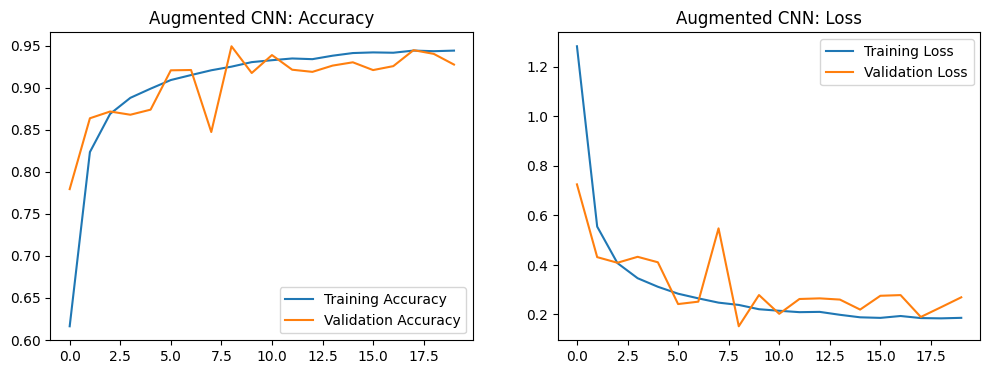

In [12]:
plot_history(history_2, "Augmented CNN")

## 3. Network Building (Feature Extraction) "MobileNetV2"

#### Loading the model (MobileNetV2), Freezing layers, Defining amd Compiling.

In [5]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    print("Running on TPU")
except:
    strategy = tf.distribute.MirroredStrategy()
    print("Running on GPU")

print(f"Number of accelerators: {strategy.num_replicas_in_sync}")

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Running on GPU
Number of accelerators: 1


In [6]:
with strategy.scope():
    inputs = tf.keras.Input(shape=(224, 224, 3))

    # Data Augmentation
    x = layers.RandomFlip("horizontal_and_vertical")(inputs)
    x = layers.RandomRotation(0.2)(x)
    x = layers.RandomZoom(0.1)(x)

    x = tf.keras.applications.mobilenet_v2.preprocess_input(x)

    # Defining Model
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(224, 224, 3),
        include_top=False, 
        weights='imagenet'
    )
    # Freeze
    base_model.trainable = False

    x = base_model(x, training=False)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(CLASSES, activation='softmax')(x)

    model_3 = tf.keras.Model(inputs, outputs, name="MobileNetV2_PlantDisease")

    # Compile
    model_3.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

model_3.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "MobileNetV2_PlantDisease"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 38)             │        48,678 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,306,662 (8.80 MB)

 Trainable params: 48,678 (190.15 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

#### Fitting Model

In [7]:
history_3 = model_3.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Epoch 1/20


I0000 00:00:1766829975.685023     134 cuda_dnn.cc:529] Loaded cuDNN version 91002


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7655 - loss: 0.8570INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
3515/3515 ━━━━━━━━━━━━━━━━━━━━ 134s 34ms/step - accuracy: 0.7655 - loss: 0.8569 - val_accuracy: 0.9033 - val_loss: 0.3007
Epoch 2/20
3515/3515 ━━━━━━━━━━━━━━━━━━━━ 117s 31ms/step - accuracy: 0.9075 - loss: 0.2863 - val_accuracy: 0.9129 - val_loss: 0.2713
Epoch 3/20
3515/3515 ━━━━━━━━━━━━━━━━━━━━ 113s 30ms/step - accuracy: 0.9171 - loss: 0.2547 - val_accuracy: 0

In [8]:
model_3.save('model_3_mobilenet_frozen.keras')

In [9]:
model_3.save('model_3_mobilenet_frozen.h5')

#### Plotting Acc/Loss Graphs!

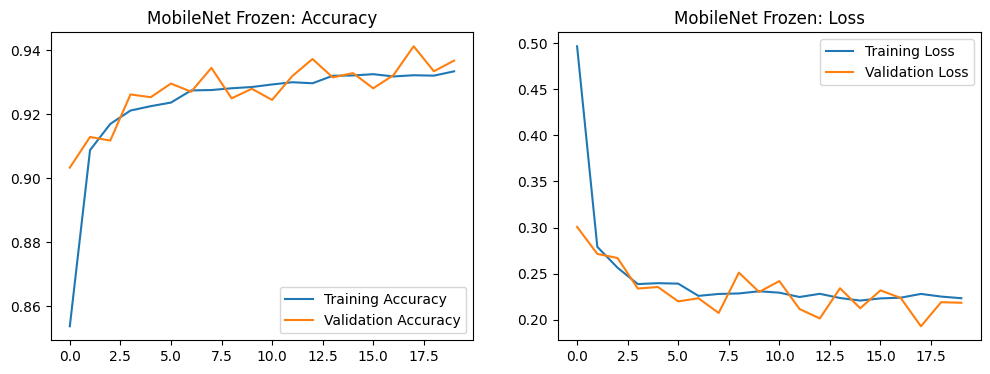

In [12]:
plot_history(history_3, "MobileNet Frozen")

## 4. Network Building (Fine Tuning)

#### Unfreezing and Recompiling!

In [13]:
base_model.trainable = True

fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

with strategy.scope():
    model_3.compile(
        optimizer=optimizers.Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

#### Early Stopping, and Fitting!

In [14]:
early_stop_fine = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

history_4 = model_3.fit(train_ds, validation_data=val_ds, epochs=40, initial_epoch=history_3.epoch[-1], callbacks=[early_stop_fine])

Epoch 20/40
3515/3515 ━━━━━━━━━━━━━━━━━━━━ 185s 48ms/step - accuracy: 0.8694 - loss: 0.5734 - val_accuracy: 0.9146 - val_loss: 0.3709
Epoch 21/40
3515/3515 ━━━━━━━━━━━━━━━━━━━━ 175s 47ms/step - accuracy: 0.9503 - loss: 0.1688 - val_accuracy: 0.9420 - val_loss: 0.2126
Epoch 22/40
3515/3515 ━━━━━━━━━━━━━━━━━━━━ 176s 47ms/step - accuracy: 0.9663 - loss: 0.1061 - val_accuracy: 0.9521 - val_loss: 0.1716
Epoch 23/40
3515/3515 ━━━━━━━━━━━━━━━━━━━━ 177s 48ms/step - accuracy: 0.9714 - loss: 0.0878 - val_accuracy: 0.9314 - val_loss: 0.3005
Epoch 24/40
3515/3515 ━━━━━━━━━━━━━━━━━━━━ 177s 48ms/step - accuracy: 0.9781 - loss: 0.0685 - val_accuracy: 0.9703 - val_loss: 0.1126
Epoch 25/40
3515/3515 ━━━━━━━━━━━━━━━━━━━━ 176s 47ms/step - accuracy: 0.9795 - loss: 0.0656 - val_accuracy: 0.9671 - val_loss: 0.1205
Epoch 26/40
3515/3515 ━━━━━━━━━━━━━━━━━━━━ 178s 48ms/step - accuracy: 0.9827 - loss: 0.0530 - val_accuracy: 0.9848 - val_loss: 0.0522
Epoch 27/40
3515/3515 ━━━━━━━━━━━━━━━━━━━━ 177s 48ms/step - ac

In [15]:
model_3.save('model_4_mobilenet_finetuned.keras')

In [16]:
model_3.save('model_4_mobilenet_finetuned.h5')

#### Plotting Acc/Loss Graphs!

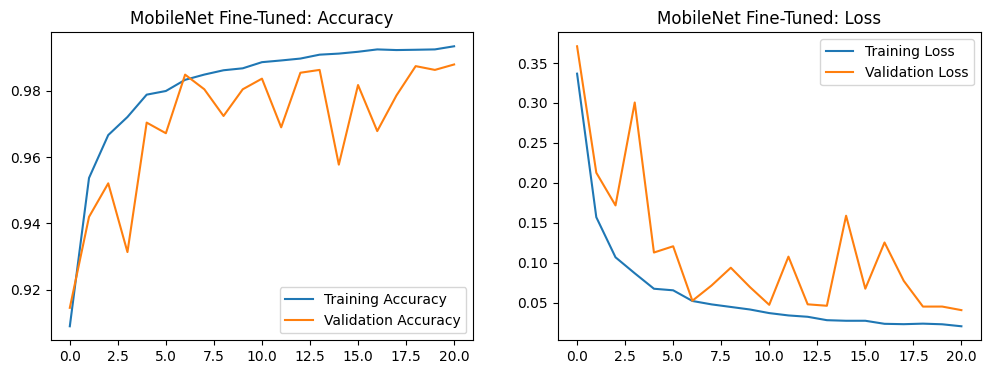

In [17]:
plot_history(history_4, "MobileNet Fine-Tuned")

#### Testing the Final Model on unseen data!

In [18]:
test_loss, test_acc = model_3.evaluate(test_ds)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

1099/1099 ━━━━━━━━━━━━━━━━━━━━ 31s 28ms/step - accuracy: 0.9927 - loss: 0.0216
Test Accuracy: 98.75%
